In [1]:
import numpy as np
import pandas as pd #this might need to be installed
import datetime
import matplotlib.pyplot as plt
import statistics as sts
from scipy.optimize import minimize,least_squares
from sympy import symbols, diff
from sympy.functions import exp
from iminuit import Minuit
#import ROOT

    # "from fibertest_fncts import frdmunits,unpack_data,unpack_and_throw_outliers" Instead we do
frdmunits=2.54 #cm/inch
def unpack_data(datafile,npos,size):

    data_list=np.transpose(np.array(pd.read_csv(datafile)))

    points=int((len(data_list)-6)/2) # This is the number of data points taken
    #size is the number of data points we want to unpack
    newpmtstd=np.empty(npos)
    newpmtmean=np.empty(npos)
    newsipmstd=np.empty(npos)
    newsipmmean=np.empty(npos)

    npmtoutlier=0
    nsipmoutlier=0

    for i in range(npos):
        np.transpose(data_list)[i][2:-(2*points-size+4)]
        stdev_pmt=sts.stdev(np.transpose(data_list)[i][2:-(2*points-size+4)])
        avg_pmt=sts.mean(np.transpose(data_list)[i][2:-(2*points-size+4)])
        newpmtdata=[]

        np.transpose(data_list)[i][-(points+4):-(4+(points-size))]
        stdev_sipm=sts.stdev(np.transpose(data_list)[i][-(points+4):-(4+(points-size))])
        avg_sipm=sts.mean(np.transpose(data_list)[i][-(points+4):-(4+(points-size))])
        newsipmdata=[]


        for j in range(len(np.transpose(data_list)[i][2:-(points-size+4)])):
            if np.transpose(data_list)[i][j+2]<avg_pmt+2*stdev_pmt and np.transpose(data_list)[i][j+2]>avg_pmt-2*stdev_pmt:
                newpmtdata.append(np.transpose(data_list)[i][j+2])
                #print("good")
            else:
                npmtoutlier+=1

        for j in range(len(np.transpose(data_list)[i][-(points+4):-(4+(points-size))])):
            if np.transpose(data_list)[i][j+points+2]<avg_sipm+2*stdev_sipm and np.transpose(data_list)[i][j+points+2]>avg_sipm-2*stdev_sipm:
                newsipmdata.append(np.transpose(data_list)[i][j+points+2])
                #print("good")
            else:
                nsipmoutlier+=1

        newpmtstd[i]=sts.stdev(newpmtdata)*10**6
        newpmtmean[i]=-sts.mean(newpmtdata)*10**6
        newsipmstd[i]=sts.stdev(newsipmdata)*10**6
        newsipmmean[i]=-sts.mean(newsipmdata)*10**6
        #print(size-len(newpmtdata))
    return np.array([newpmtmean,newpmtstd,newsipmmean,newsipmstd])
def unpack_and_throw_outliers(filename,runs):
    pmt_mean_old=-np.transpose(np.array(pd.read_csv(filename)))[-4]*10**6
    pmt_std_old=np.transpose(np.array(pd.read_csv(filename)))[-3]*10**6
    pmt_data=np.transpose(np.array(pd.read_csv(filename)))[2:-(runs+4)]*10**6 # all data taken by the pmt per position
    sipm_data=np.transpose(np.array(pd.read_csv(filename)))[-(runs+4):-4]*10**6 # all data taken by the sipm per position
    
    pmt_data_no_outliers=[]
    sipm_data_no_outliers=[]
    pmt_data_no_outliers_means=[]
    pmt_data_no_outliers_std=[]
    for i in range(25):
        data=np.transpose(pmt_data)[i]
        det_data=np.transpose(sipm_data)[i]
        # Create a box plot
        box_props = plt.boxplot(data)
        
       # plt.show()

        # Get the whisker ranges
        lower_whisker = box_props['whiskers'][0].get_ydata()[1]
        upper_whisker = box_props['whiskers'][1].get_ydata()[1]

        # Identify outliers using IQR method
        iqr = upper_whisker - lower_whisker
        lower_bound = lower_whisker
        upper_bound = upper_whisker

        outliers = np.where((data < lower_bound) | (data > upper_bound))[0]
        #print(outliers,lower_bound,upper_bound)
    
         # Remove outliers from the data
        no_outlier_pmt_data = -np.delete(data, outliers)
        no_outlier_sipm_data = np.delete(det_data, outliers)
        
        pmt_data_no_outliers.append(no_outlier_pmt_data)
        sipm_data_no_outliers.append(no_outlier_sipm_data)

        pmt_data_no_outliers_means.append(np.mean(no_outlier_pmt_data))
        pmt_data_no_outliers_std.append(np.std(no_outlier_pmt_data))
    
    
    fig = plt.figure(figsize=(16, 10), dpi=80)
    # Error propagation formula for the ratio
    #err = (lsr_crctd_data_mean/pmt_mean_old) * np.sqrt((lsr_crctd_data_stdev / lsr_crctd_data_mean)**2 + (pmt_std_old / pmt_mean_old)**2)
    err = (pmt_data_no_outliers_std/pmt_mean_old)
    plt.errorbar(pos,pmt_data_no_outliers_means/pmt_mean_old,yerr=err, fmt="o", color="k",capsize=5,label='Ratio of corrected to raw data')
    #plt.errorbar(pos,pmt_mean_old, yerr=pmt_std_old, fmt="o", color="b",capsize=5,label='Fiber')
    plt.legend()
    plt.show()
    return         pmt_data_no_outliers, sipm_data_no_outliers, pmt_data_no_outliers_means, pmt_data_no_outliers_std

# Getting data from Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

x0=(1.5+2.75)*2.54 #cm/inch
UncutL=209.2#(4+73.5)*2.54+x0 #cm/inch
RefurbL=208.2
L_err=0.125*frdmunits
pos=np.transpose(np.array(pd.read_csv("fibertest_002232.csv")))[0]*frdmunits+x0
pos_zero=np.concatenate((pos, [0.]))

uncut="fibertest_002232.csv"
cut="fibertest_002233.csv"
ref="fibertest_002234.csv"

In [2]:
pos

array([197.485  , 189.70625, 181.9275 , 174.14875, 166.37   , 158.59125,
       150.8125 , 143.03375, 135.255  , 127.47625, 119.6975 , 111.91875,
       104.14   ,  96.36125,  88.5825 ,  80.80375,  73.025  ,  65.24625,
        57.4675 ,  49.68875,  41.91   ,  34.13125,  26.3525 ,  18.57375,
        10.795  ])

In [3]:
#Uncut
uncut_fiber3_pmt_data=np.transpose(np.transpose(np.array(pd.read_csv(uncut)))[2:-104])
uncut_fiber3_sipm_data=np.transpose(np.transpose(np.array(pd.read_csv(uncut)))[-104:-4])
uncut_fiber3_pmt_means=np.transpose(np.transpose(np.array(pd.read_csv(uncut)))[-4])
uncut_fiber3_pmt_std=np.transpose(np.transpose(np.array(pd.read_csv(uncut)))[-3])
uncut_fiber3_sipm_means=np.transpose(np.transpose(np.array(pd.read_csv(uncut)))[-2])
uncut_fiber3_sipm_std=np.transpose(np.transpose(np.array(pd.read_csv(uncut)))[-1])

#Cut
cut_fiber3_pmt_data=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[2:-104])
cut_fiber3_sipm_data=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[-104:-4])
cut_fiber3_pmt_means=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[-4])
cut_fiber3_pmt_std=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[-3])
cut_fiber3_sipm_means=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[-2])
cut_fiber3_sipm_std=np.transpose(np.transpose(np.array(pd.read_csv(cut)))[-1])

#Refurb
ref_fiber3_pmt_data=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[2:-104])
ref_fiber3_sipm_data=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[-104:-4])
ref_fiber3_pmt_means=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[-4])
ref_fiber3_pmt_std=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[-3])
ref_fiber3_sipm_means=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[-2])
ref_fiber3_sipm_std=np.transpose(np.transpose(np.array(pd.read_csv(ref)))[-1])

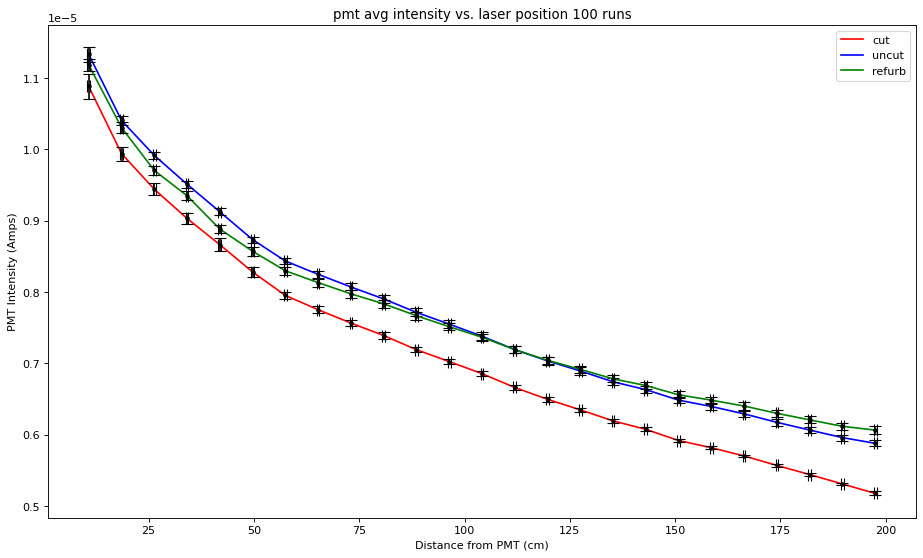

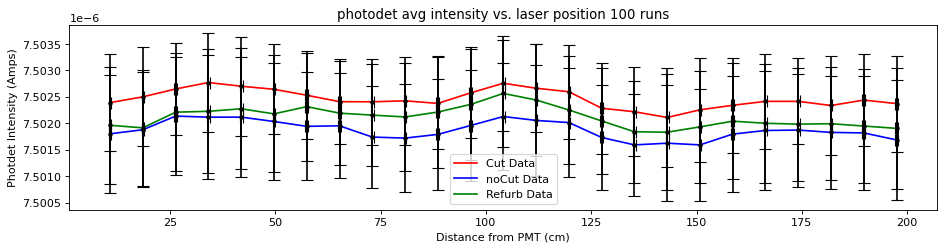

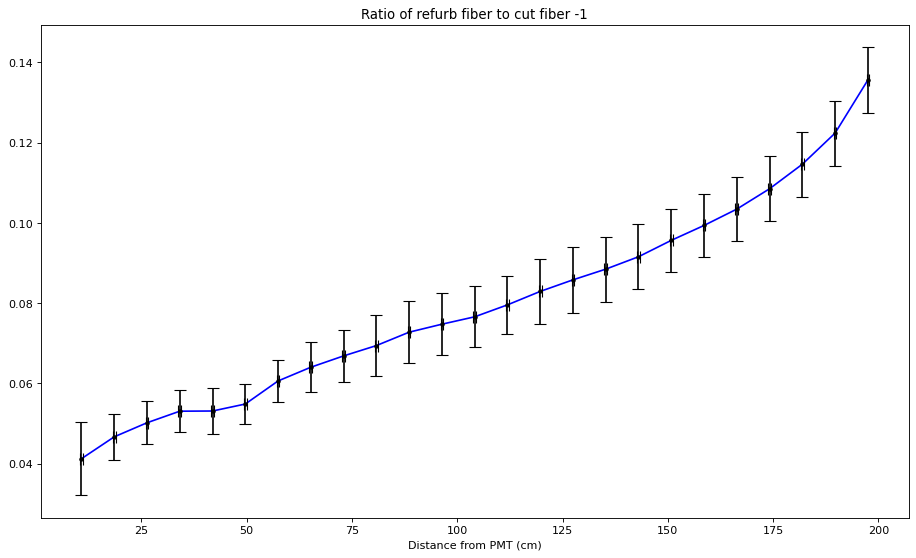

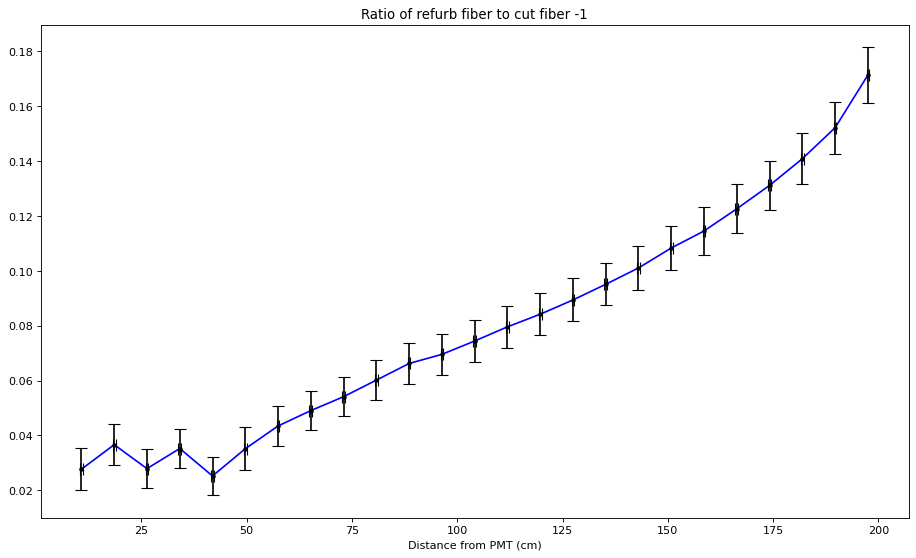

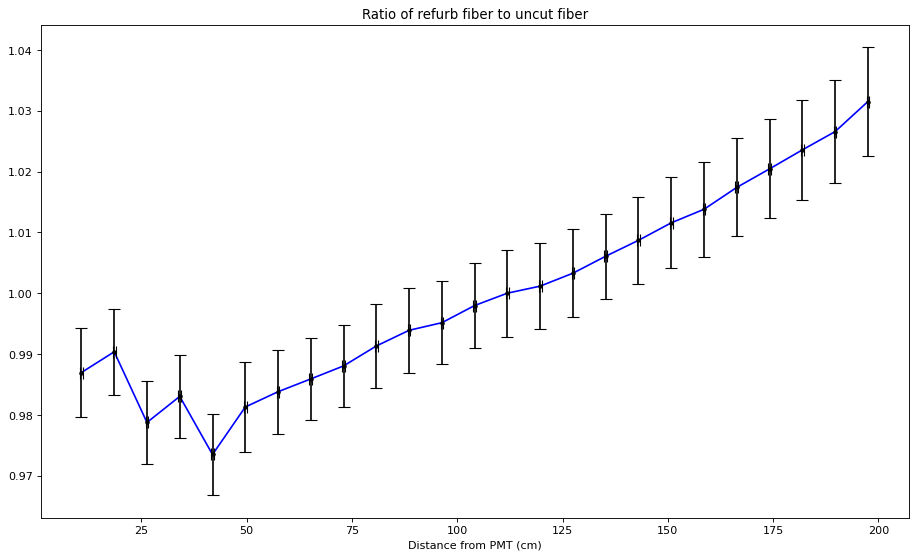

In [4]:
#a_scale_factor=np.mean(refurb_fiber2_sipm_means)/np.mean(fiber2_sipm_means)
fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,-cut_fiber3_pmt_means,color='r')
plt.errorbar(pos,-cut_fiber3_pmt_means, xerr=L_err,yerr=cut_fiber3_pmt_std, fmt=".", color="k",capsize=5)
plt.plot(pos,-uncut_fiber3_pmt_means,color='b')
plt.errorbar(pos,-uncut_fiber3_pmt_means, xerr=L_err, yerr=uncut_fiber3_pmt_std, fmt=".", color="k",capsize=5)
plt.plot(pos,-ref_fiber3_pmt_means,color='g')
plt.errorbar(pos,-ref_fiber3_pmt_means, xerr=L_err, yerr=ref_fiber3_pmt_std, fmt=".", color="k",capsize=5)
plt.title("pmt avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (Amps)")
plt.legend(['cut', 'uncut','refurb'])
plt.show()
fig = plt.figure(figsize=(14, 3), dpi=80)
plt.plot(pos,cut_fiber3_sipm_means,color='r')
plt.errorbar(pos,cut_fiber3_sipm_means, xerr=L_err,yerr=cut_fiber3_sipm_std, fmt=".", color="k",capsize=5)
plt.plot(pos,uncut_fiber3_sipm_means,color='b')
plt.errorbar(pos,uncut_fiber3_sipm_means, xerr=L_err,yerr=ref_fiber3_sipm_std, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_fiber3_sipm_means,color='g')
plt.errorbar(pos,ref_fiber3_sipm_means, xerr=L_err,yerr=ref_fiber3_sipm_std, fmt=".", color="k",capsize=5)
plt.title("photodet avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("Photdet Intensity (Amps)")
plt.legend(['Cut Data', 'noCut Data','Refurb Data'])
plt.show()

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,uncut_fiber3_pmt_means/cut_fiber3_pmt_means-1,color='b')
plt.errorbar(pos,uncut_fiber3_pmt_means/cut_fiber3_pmt_means-1, xerr=L_err, yerr=-uncut_fiber3_pmt_std/cut_fiber3_pmt_means, fmt=".", color="k",capsize=5)
plt.title("Ratio of refurb fiber to cut fiber -1")
plt.xlabel("Distance from PMT (cm)")
plt.show()

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,ref_fiber3_pmt_means/cut_fiber3_pmt_means-1,color='b')
plt.errorbar(pos,ref_fiber3_pmt_means/cut_fiber3_pmt_means-1, xerr=L_err, yerr=-ref_fiber3_pmt_std/cut_fiber3_pmt_means, fmt=".", color="k",capsize=5)
plt.title("Ratio of refurb fiber to cut fiber -1")
plt.xlabel("Distance from PMT (cm)")
plt.show()

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,ref_fiber3_pmt_means/uncut_fiber3_pmt_means,color='b')
plt.errorbar(pos,ref_fiber3_pmt_means/uncut_fiber3_pmt_means, xerr=L_err, yerr=-ref_fiber3_pmt_std/uncut_fiber3_pmt_means, fmt=".", color="k",capsize=5)
plt.title("Ratio of refurb fiber to uncut fiber")
plt.xlabel("Distance from PMT (cm)")
plt.show()


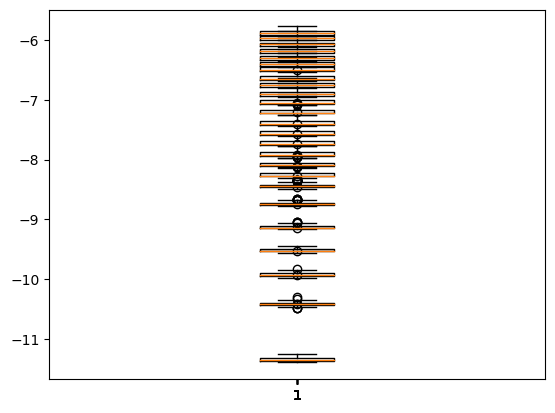

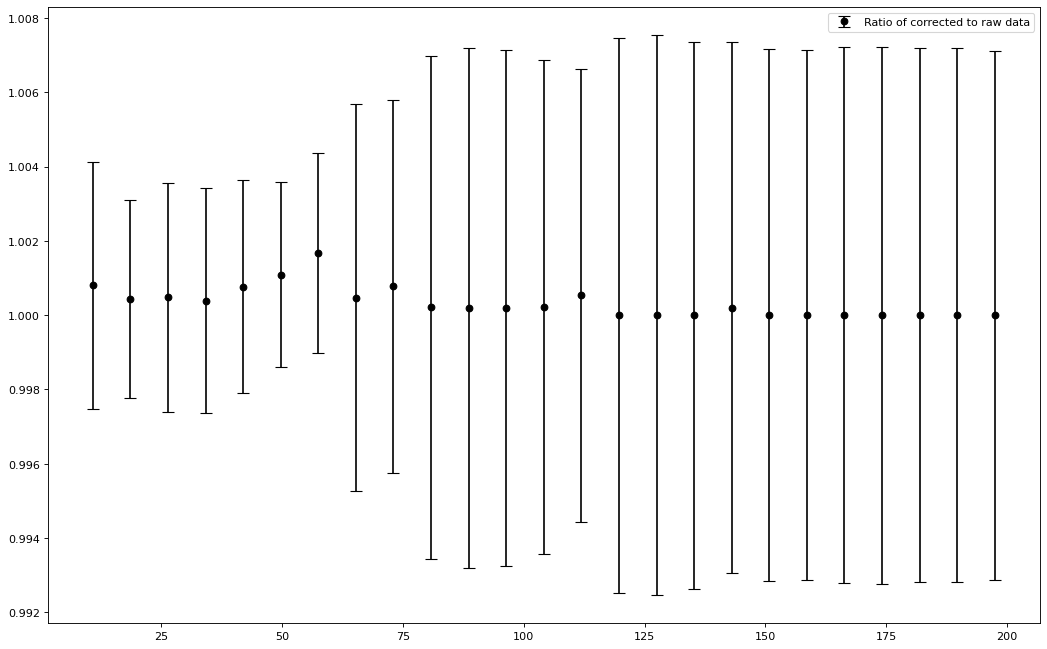

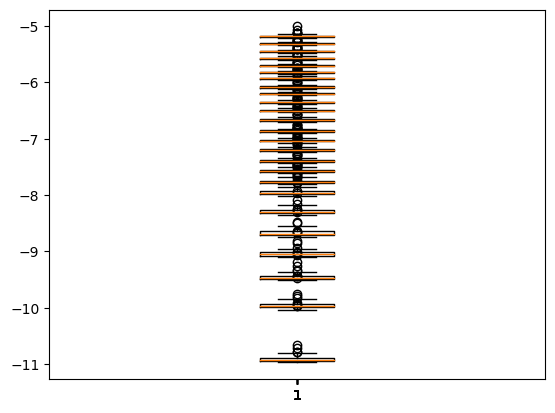

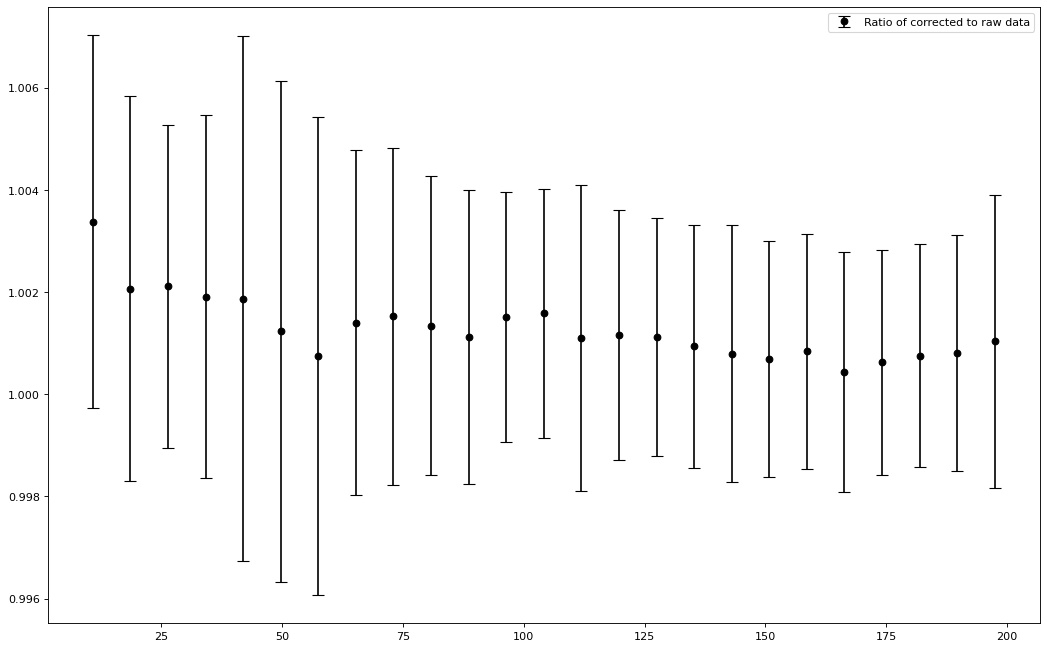

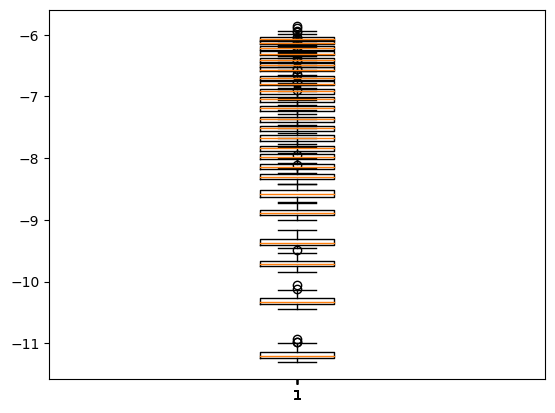

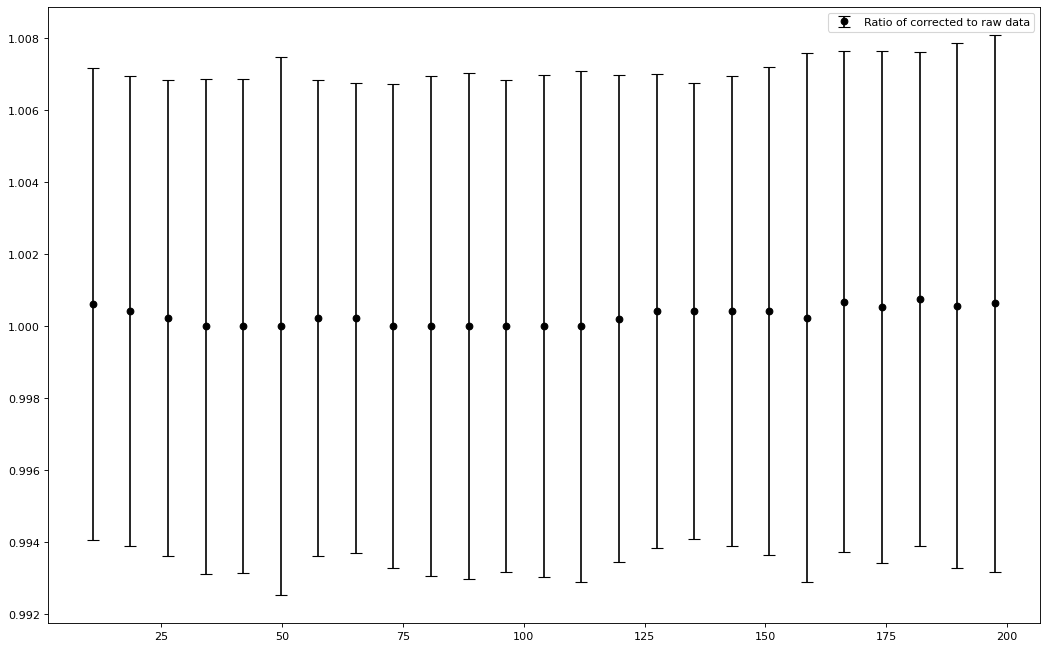

In [5]:
pmt_uncut_no_outliers,det_uncut_no_outliers,pmt_uncut_no_outliers_means, pmt_uncut_no_outliers_std=unpack_and_throw_outliers(uncut,100)
pmt_cut_no_outliers,det_cut_no_outliers,pmt_cut_no_outliers_means, pmt_cut_no_outliers_std=unpack_and_throw_outliers(cut,100)
pmt_ref_no_outliers,det_ref_no_outliers,pmt_ref_no_outliers_means, pmt_ref_no_outliers_std=unpack_and_throw_outliers(ref,100)

In [6]:
#Uncut
det_uncut_no_outliers_means=np.empty(25)
det_uncut_no_outliers_std=np.empty(25)
#Cut
det_cut_no_outliers_means=np.empty(25)
det_cut_no_outliers_std=np.empty(25)
#Refurb
det_ref_no_outliers_means=np.empty(25)
det_ref_no_outliers_std=np.empty(25)

for i in range(25):
    det_uncut_no_outliers_means[i]=np.mean(det_uncut_no_outliers[i])
    det_uncut_no_outliers_std[i]=np.std(det_uncut_no_outliers[i])
    det_cut_no_outliers_means[i]=np.mean(det_cut_no_outliers[i])
    det_cut_no_outliers_std[i]=np.std(det_cut_no_outliers[i])
    det_ref_no_outliers_means[i]=np.mean(det_ref_no_outliers[i])
    det_ref_no_outliers_std[i]=np.std(det_ref_no_outliers[i])

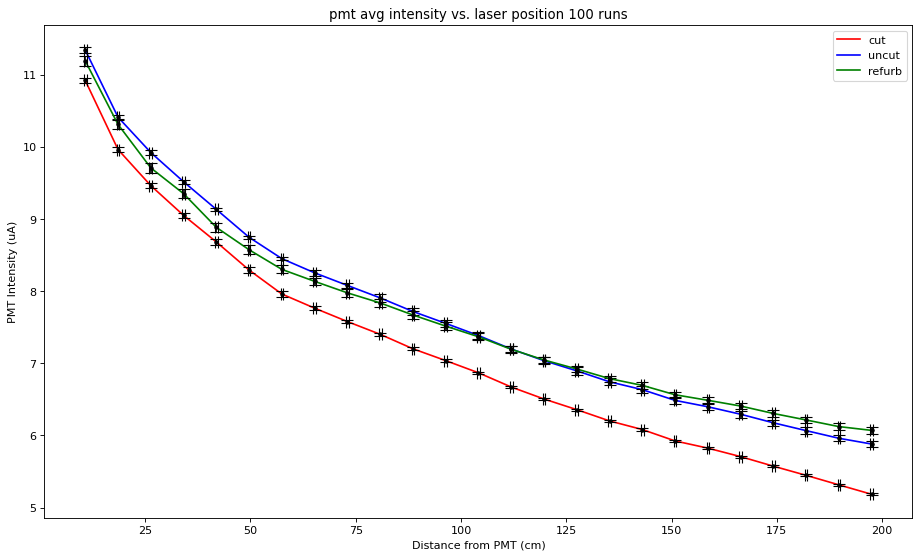

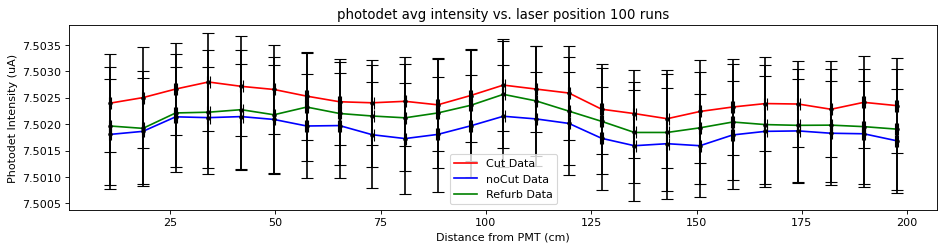

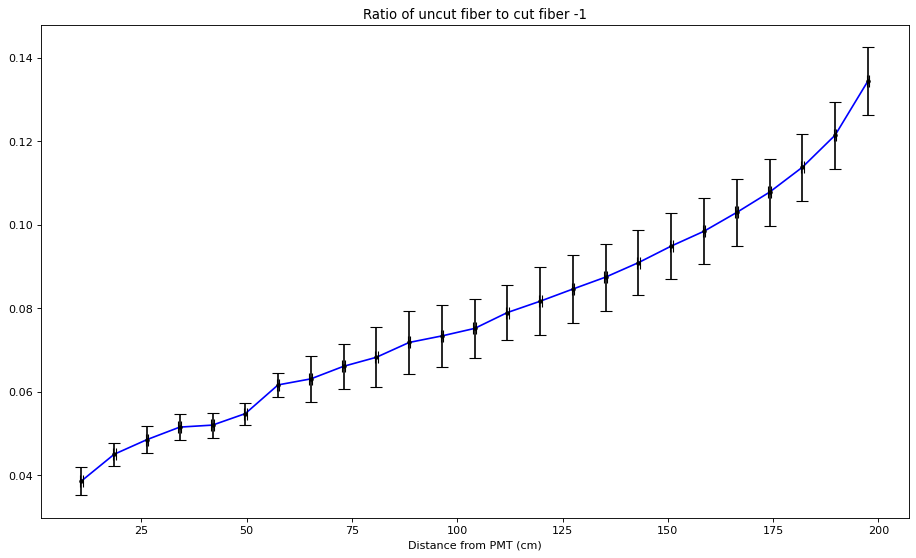

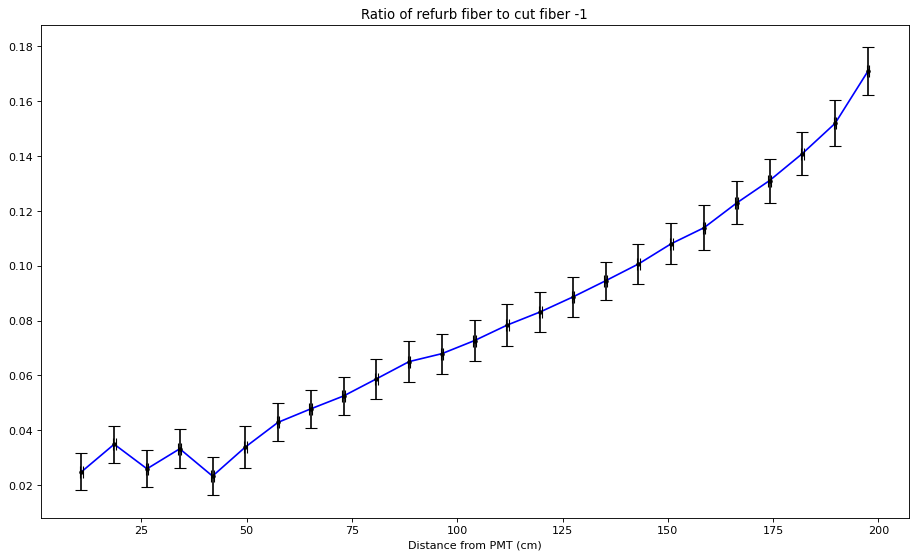

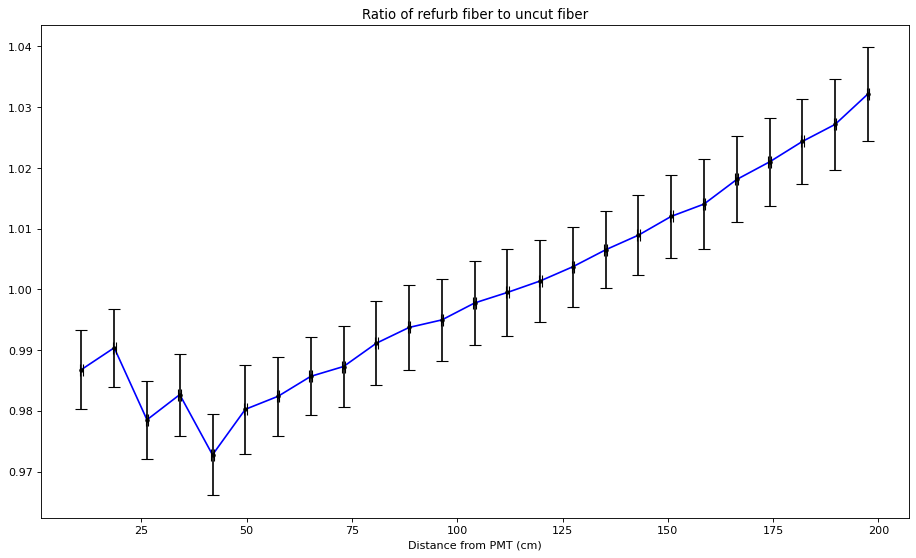

In [7]:
#a_scale_factor=np.mean(refurb_fiber2_sipm_means)/np.mean(fiber2_sipm_means)
fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,pmt_cut_no_outliers_means,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,pmt_uncut_no_outliers_means,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means, xerr=L_err, yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,pmt_ref_no_outliers_means,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means, xerr=L_err, yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.title("pmt avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['cut', 'uncut','refurb'])
plt.show()
fig = plt.figure(figsize=(14, 3), dpi=80)
plt.plot(pos,det_cut_no_outliers_means,color='r')
plt.errorbar(pos,det_cut_no_outliers_means, xerr=L_err,yerr=det_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,det_uncut_no_outliers_means,color='b')
plt.errorbar(pos,det_uncut_no_outliers_means, xerr=L_err,yerr=det_uncut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,det_ref_no_outliers_means,color='g')
plt.errorbar(pos,det_ref_no_outliers_means, xerr=L_err,yerr=det_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.title("photodet avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("Photodet Intensity (uA)")
plt.legend(['Cut Data', 'noCut Data','Refurb Data'])
plt.show()

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,np.array(pmt_uncut_no_outliers_means)/np.array(pmt_cut_no_outliers_means)-1,color='b')
plt.errorbar(pos,np.array(pmt_uncut_no_outliers_means)/np.array(pmt_cut_no_outliers_means)-1, xerr=L_err, yerr=np.array(pmt_uncut_no_outliers_std)/np.array(pmt_cut_no_outliers_means), fmt=".", color="k",capsize=5)
plt.title("Ratio of uncut fiber to cut fiber -1")
plt.xlabel("Distance from PMT (cm)")
plt.show()

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,np.array(pmt_ref_no_outliers_means)/np.array(pmt_cut_no_outliers_means)-1,color='b')
plt.errorbar(pos,np.array(pmt_ref_no_outliers_means)/np.array(pmt_cut_no_outliers_means)-1, xerr=L_err, yerr=np.array(pmt_ref_no_outliers_std)/np.array(pmt_cut_no_outliers_means), fmt=".", color="k",capsize=5)
plt.title("Ratio of refurb fiber to cut fiber -1")
plt.xlabel("Distance from PMT (cm)")
plt.show()

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,np.array(pmt_ref_no_outliers_means)/np.array(pmt_uncut_no_outliers_means),color='b')
plt.errorbar(pos,np.array(pmt_ref_no_outliers_means)/np.array(pmt_uncut_no_outliers_means), xerr=L_err, yerr=np.array(pmt_ref_no_outliers_std)/np.array(pmt_uncut_no_outliers_means), fmt=".", color="k",capsize=5)
plt.title("Ratio of refurb fiber to uncut fiber")
plt.xlabel("Distance from PMT (cm)")
plt.show()


In [8]:
def Attenuation(x, a, A_L, A_S ):
    return (a*np.exp(-(x)/A_L)+np.abs(1-a)*np.exp(-(x)/A_S))
def Attenuation_w_Reflection(x, a, A_L, A_S, R,L):
    return Attenuation(x,a,A_L,A_S)+R*Attenuation(2*L-x,a,A_L,A_S)

def minimize_without_reflection_cut(Q, a, A_L, A_S):
    res=(pmt_cut_no_outliers_means-Q*Attenuation(pos,a,A_L,A_S))/pmt_cut_no_outliers_std
    return np.sum(res**2)
def minimize_with_reflection_uncut(Q, a, A_L, A_S,R):
    res=(pmt_uncut_no_outliers_means-Q*Attenuation_w_Reflection(pos,a,A_L,A_S,R,UncutL))/pmt_uncut_no_outliers_std
    return np.sum(res**2)
def minimize_with_reflection_ref(Q, a, A_L, A_S,R):
    res=(pmt_ref_no_outliers_means-Q*Attenuation_w_Reflection(pos,a,A_L,A_S,R,RefurbL))/pmt_ref_no_outliers_std
    return np.sum(res**2)

In [9]:
# Individual fits

#Uncut
# Create a Minuit object
uncut_Min = Minuit(minimize_with_reflection_uncut, Q=11.8, a=.73, A_L=450, A_S=20,R=0)

# Perform the minimization
result = uncut_Min.migrad()

# Print the result
print("Minimization result: Fiber with Reflection (Uncut)")
print(result)
cov_matrix_uncut=uncut_Min.covariance
param_errors=uncut_Min.errors
corr_matrix_uncut = cov_matrix_uncut / np.outer(param_errors, param_errors)
print(corr_matrix_uncut)
print("Optimal parameters:", uncut_Min.values)
print("Parameters Errors:", uncut_Min.errors)


#Cut
# Create a Minuit object
cut_Min = Minuit(minimize_without_reflection_cut, Q=10, a=.73, A_L=322, A_S=10)

# Perform the minimization
result = cut_Min.migrad()

# Print the result
print("Minimization result: Fiber without Reflection (Cut)")
print(result)
cov_matrix_cut=cut_Min.covariance
param_errors=cut_Min.errors
corr_matrix_cut = cov_matrix_cut / np.outer(param_errors, param_errors)
print(corr_matrix_cut)
print("Optimal parameters:", cut_Min.values)
print("Parameters Errors:", cut_Min.errors)

#Refurb
# Create a Minuit object
ref_Min = Minuit(minimize_with_reflection_ref, Q=11.8, a=.73, A_L=450, A_S=10,R=0)

# Perform the minimization
result = ref_Min.migrad()

# Print the result
print("Minimization result: Fiber with Reflection (Refurb)")
print(result)
cov_matrix_ref=ref_Min.covariance
param_errors=ref_Min.errors
corr_matrix_ref = cov_matrix_ref / np.outer(param_errors, param_errors)
print(corr_matrix_ref)
print("Optimal parameters:", ref_Min.values)
print("Parameters Errors:", ref_Min.errors)

uncut_fit=uncut_Min.values['Q']*Attenuation_w_Reflection(pos,uncut_Min.values['a'],uncut_Min.values['A_L'],uncut_Min.values['A_S'],uncut_Min.values['R'],UncutL)
cut_fit=cut_Min.values['Q']*Attenuation(pos,cut_Min.values['a'],cut_Min.values['A_L'],cut_Min.values['A_S'])
ref_fit=ref_Min.values['Q']*Attenuation_w_Reflection(pos,ref_Min.values['a'],ref_Min.values['A_L'],ref_Min.values['A_S'],ref_Min.values['R'],RefurbL)

Minimization result: Fiber with Reflection (Uncut)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 32.93                      │              Nfcn = 624              │
│ EDM = 0.000177 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬─

In [10]:
cut_Min.values['Q']

12.380069304254771

In [71]:
#Joint (all three) Min

def joint_minimization_all(Q,a,A_L,A_S,R):
    data=np.concatenate([pmt_uncut_no_outliers_means,pmt_cut_no_outliers_means,pmt_ref_no_outliers_means])
    model=Q*np.concatenate([Attenuation_w_Reflection(pos,a,A_L,A_S,R,UncutL),Attenuation(pos,a,A_L,A_S),Attenuation_w_Reflection(pos,a,A_L,A_S,R,RefurbL)])
    err=np.concatenate([pmt_uncut_no_outliers_std,pmt_cut_no_outliers_std,pmt_ref_no_outliers_std])
    cost=(data-model)/err
    return np.sum(cost**2)
def joint_minimization_uncut_cut(Q,a,A_L,A_S,R):
    data=np.concatenate([pmt_uncut_no_outliers_means,pmt_cut_no_outliers_means])
    model=Q*np.concatenate([Attenuation_w_Reflection(pos,a,A_L,A_S,R,UncutL),Attenuation(pos,a,A_L,A_S)])
    err=np.concatenate([pmt_uncut_no_outliers_std,pmt_cut_no_outliers_std])
    cost=(data-model)/err
    return np.sum(cost**2)
def joint_minimization_ref_cut(Q,a,A_L,A_S,R):
    data=np.concatenate([pmt_cut_no_outliers_means,pmt_ref_no_outliers_means])
    model=Q*np.concatenate([Attenuation(pos,a,A_L,A_S),Attenuation_w_Reflection(pos,a,A_L,A_S,R,RefurbL)])
    err=np.concatenate([pmt_cut_no_outliers_std,pmt_ref_no_outliers_std])
    cost=(data-model)/err
    return np.sum(cost**2)
def joint_minimization_uncut_ref(Q,a,A_L,A_S,R):
    data=np.concatenate([pmt_uncut_no_outliers_means,pmt_ref_no_outliers_means])
    model=Q*np.concatenate([Attenuation_w_Reflection(pos,a,A_L,A_S,R,UncutL),Attenuation_w_Reflection(pos,a,A_L,A_S,R,RefurbL)])
    err=np.concatenate([pmt_uncut_no_outliers_std,pmt_ref_no_outliers_std])
    cost=(data-model)/err
    return np.sum(cost**2)

# Create a Minuit object
Joint_Min = Minuit(joint_minimization_all, Q=11, a=.73, A_L=450, A_S=20, R=0)
UncutJoint_Min = Minuit(joint_minimization_uncut_cut, Q=11, a=.73, A_L=450, A_S=20, R=0)
RefJoint_Min = Minuit(joint_minimization_ref_cut, Q=11, a=.73, A_L=450, A_S=20, R=0)
URJoint_Min = Minuit(joint_minimization_uncut_ref, Q=11, a=.73, A_L=450, A_S=20, R=0)

# Perform the minimization
result1 = Joint_Min.migrad()
result2 = UncutJoint_Min.migrad()
result3 = RefJoint_Min.migrad()
result4 = URJoint_Min.migrad()

# Print the result
print("Minimization result: Joint Fit (all three)")
print(result1)
cov_matrix_Joint=Joint_Min.covariance
param_errors1=Joint_Min.errors
corr_matrix_Joint = cov_matrix_Joint / np.outer(param_errors1, param_errors1)
print(corr_matrix_Joint)
print("Optimal parameters:", Joint_Min.values)
print("Parameters Errors:", Joint_Min.errors)

print("Minimization result: Joint Fit (Uncut/Cut)")
print(result2)
cov_matrix_UncutJoint=UncutJoint_Min.covariance
param_errors2=UncutJoint_Min.errors
corr_matrix_UncutJoint = cov_matrix_UncutJoint / np.outer(param_errors2, param_errors2)
print(corr_matrix_UncutJoint)
print("Optimal parameters:", UncutJoint_Min.values)
print("Parameters Errors:", UncutJoint_Min.errors)

print("Minimization result: Joint Fit (Refurb/Cut)")
print(result3)
cov_matrix_RefJoint=RefJoint_Min.covariance
param_errors3=RefJoint_Min.errors
corr_matrix_RefJoint = cov_matrix_RefJoint / np.outer(param_errors3, param_errors3)
print(corr_matrix_RefJoint)
print("Optimal parameters:", RefJoint_Min.values)
print("Parameters Errors:", RefJoint_Min.errors)

print("Minimization result: Joint Fit (Uncut/Refurb)")
print(result4)
cov_matrix_URJoint=URJoint_Min.covariance
param_errors4=URJoint_Min.errors
corr_matrix_URJoint = cov_matrix_URJoint / np.outer(param_errors4, param_errors4)
print(corr_matrix_URJoint)
print("Optimal parameters:", URJoint_Min.values)
print("Parameters Errors:", URJoint_Min.errors)

uncut_Joint_all_fit=Joint_Min.values['Q']*Attenuation_w_Reflection(pos,Joint_Min.values['a'],Joint_Min.values['A_L'],Joint_Min.values['A_S'],Joint_Min.values['R'],UncutL)
cut_Joint_all_fit=Joint_Min.values['Q']*Attenuation(pos,Joint_Min.values['a'],Joint_Min.values['A_L'],Joint_Min.values['A_S'])
ref_Joint_all_fit=Joint_Min.values['Q']*Attenuation_w_Reflection(pos,Joint_Min.values['a'],Joint_Min.values['A_L'],Joint_Min.values['A_S'],Joint_Min.values['R'],RefurbL)

uncut_UncutJoint_fit=UncutJoint_Min.values['Q']*Attenuation_w_Reflection(pos,UncutJoint_Min.values['a'],UncutJoint_Min.values['A_L'],UncutJoint_Min.values['A_S'],UncutJoint_Min.values['R'],UncutL)
cut_UncutJoint_fit=UncutJoint_Min.values['Q']*Attenuation(pos,UncutJoint_Min.values['a'],UncutJoint_Min.values['A_L'],UncutJoint_Min.values['A_S'])

ref_RefJoint_fit=RefJoint_Min.values['Q']*Attenuation_w_Reflection(pos,RefJoint_Min.values['a'],RefJoint_Min.values['A_L'],RefJoint_Min.values['A_S'],RefJoint_Min.values['R'],RefurbL)
cut_RefJoint_fit=RefJoint_Min.values['Q']*Attenuation(pos,RefJoint_Min.values['a'],RefJoint_Min.values['A_L'],RefJoint_Min.values['A_S'])

uncut_URJoint_fit=URJoint_Min.values['Q']*Attenuation_w_Reflection(pos,URJoint_Min.values['a'],URJoint_Min.values['A_L'],URJoint_Min.values['A_S'],URJoint_Min.values['R'],UncutL)
ref_URJoint_fit=URJoint_Min.values['Q']*Attenuation_w_Reflection(pos,URJoint_Min.values['a'],URJoint_Min.values['A_L'],URJoint_Min.values['A_S'],URJoint_Min.values['R'],RefurbL)


Minimization result: Joint Fit (all three)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 183                        │              Nfcn = 293              │
│ EDM = 6.31e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬─────────

In [15]:
# This cell is in a misleading place, definitions to be used later

def Attenuation_w_const(x, a, b, A_L, A_S, A_x ):
    return (a*np.exp(-(x)/A_L)+np.abs(1-a-b)*np.exp(-(x)/A_S)) + b*A_x
def Attenuation_w_Reflection_w_const(x, a,b, A_L, A_S, A_x, R,L):
    return Attenuation_w_const(x,a,b,A_L,A_S,A_x)+R*Attenuation_w_const(2*L-x,a,b,A_L,A_S,A_x)

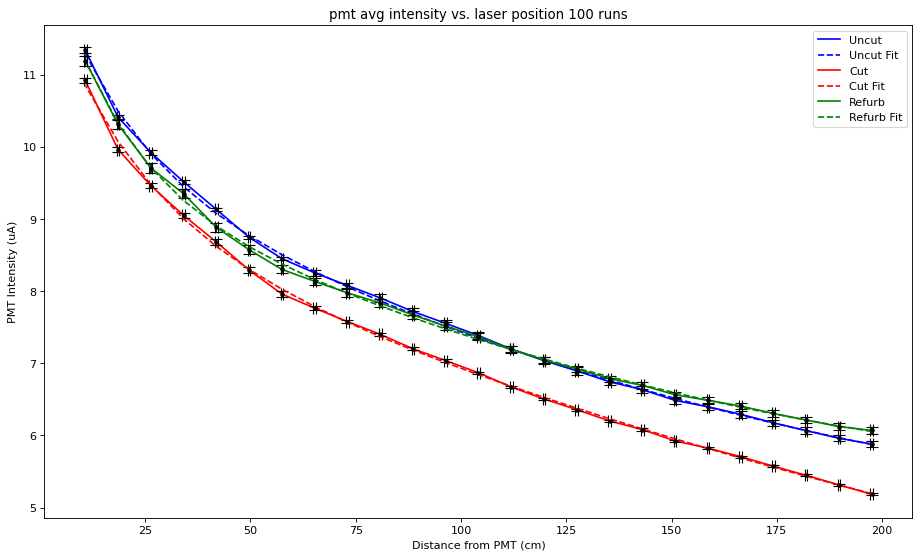

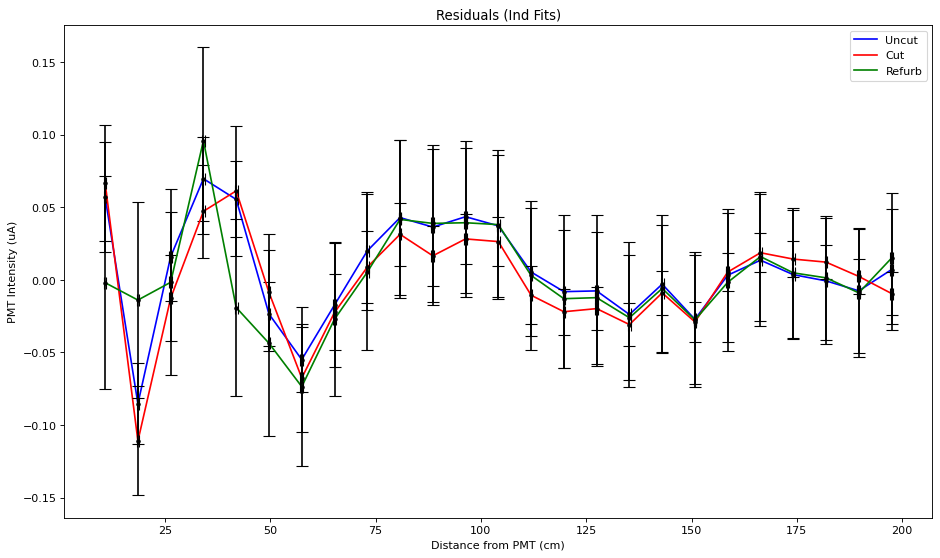

In [16]:
# Individual Fits (One Graph)

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,pmt_uncut_no_outliers_means,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,uncut_fit,color='b', linestyle='dashed')
# uncut error bars
plt.plot(pos,pmt_cut_no_outliers_means,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_fit,color='r', linestyle='dashed')
plt.plot(pos,pmt_ref_no_outliers_means,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_fit,color='g', linestyle='dashed')
plt.title("pmt avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals
fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,pmt_uncut_no_outliers_means-uncut_fit,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means-uncut_fit, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_cut_no_outliers_means-cut_fit,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means-cut_fit, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_means-ref_fit,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means-ref_fit, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)

plt.title("Residuals (Ind Fits)")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Cut','Refurb'])
plt.show()

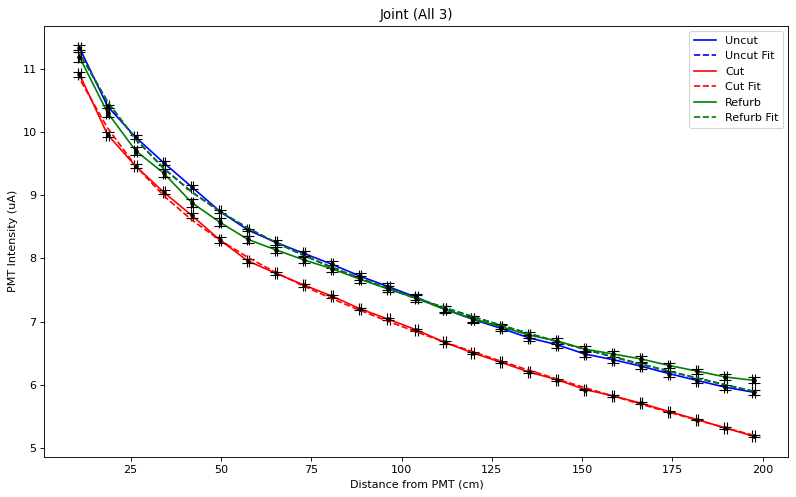

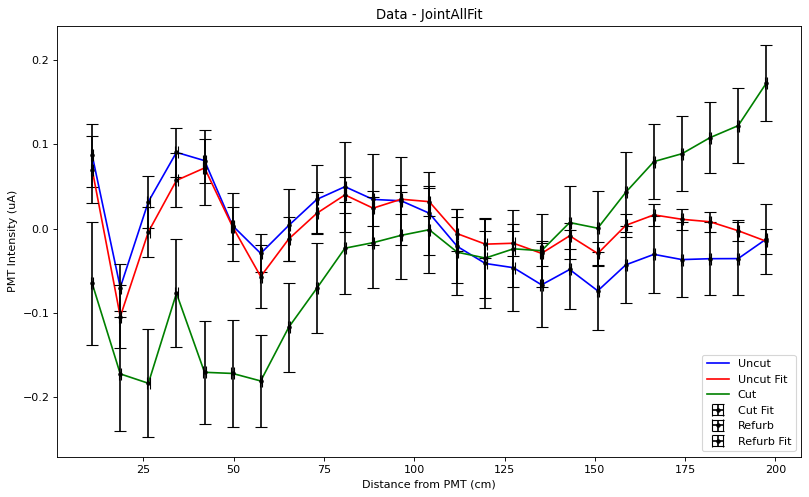

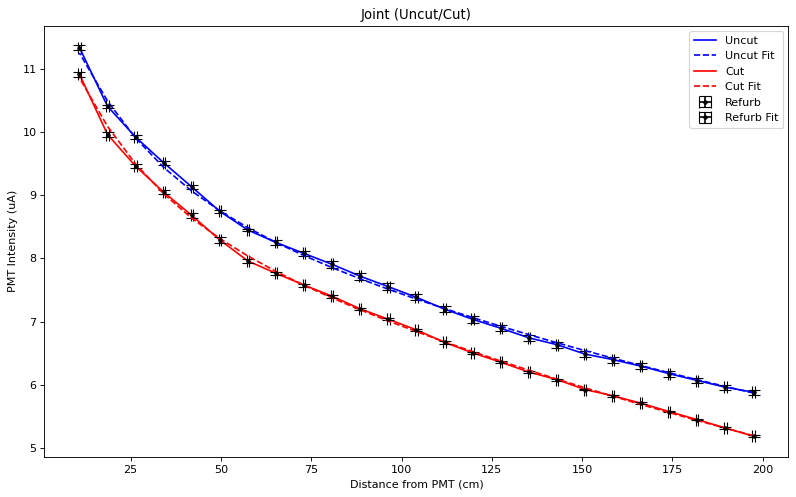

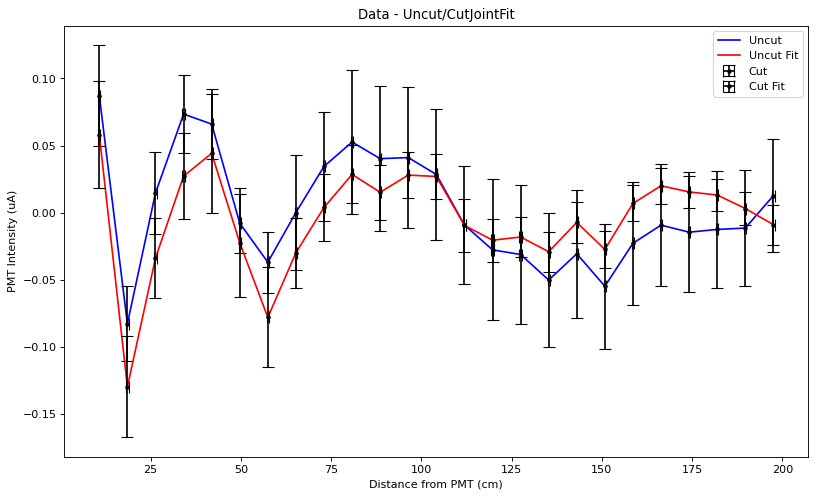

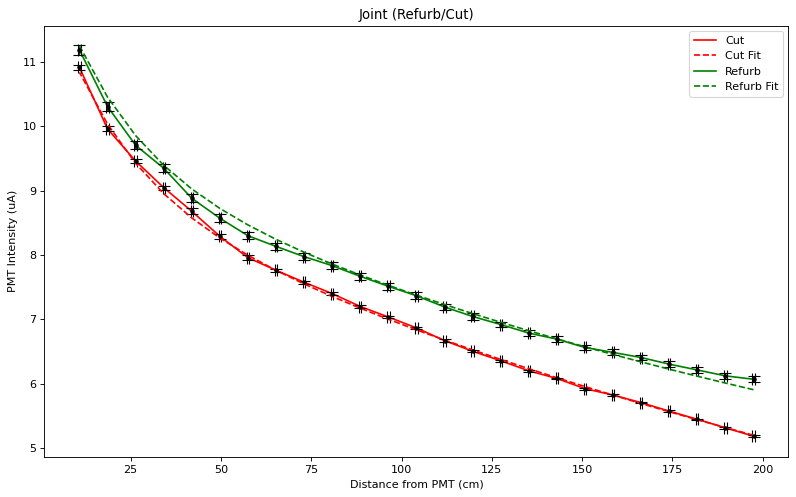

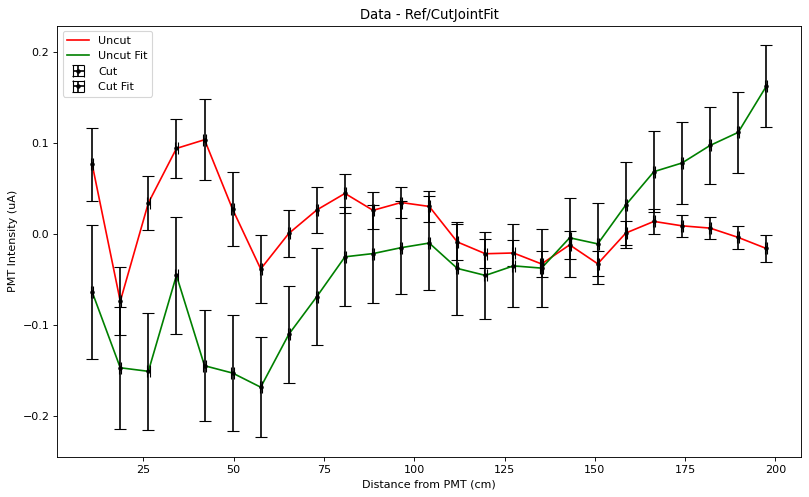

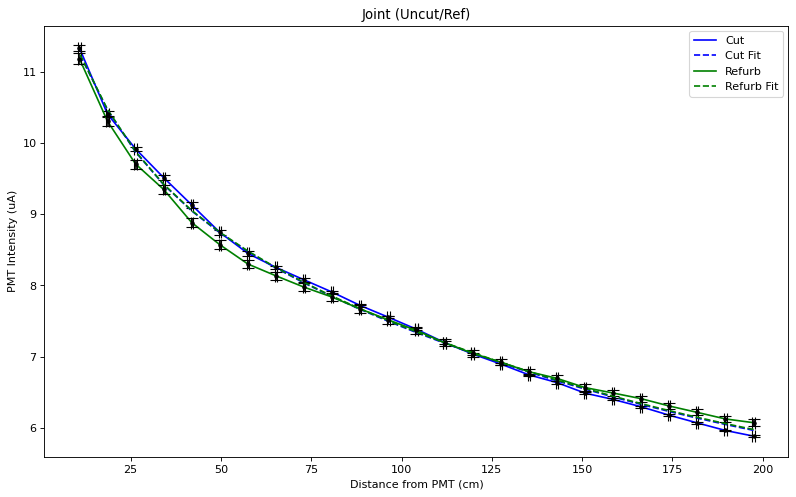

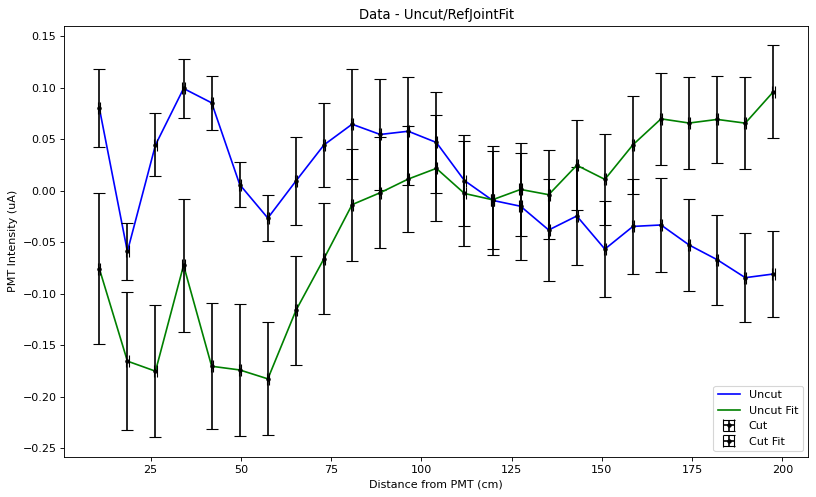

In [73]:
# Joint all 3 Fits (One Graph)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos,pmt_uncut_no_outliers_means,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,uncut_Joint_all_fit,color='b',linestyle='dashed')
plt.plot(pos,pmt_cut_no_outliers_means,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_Joint_all_fit,color='r',linestyle='dashed')
plt.plot(pos,pmt_ref_no_outliers_means,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_Joint_all_fit,color='g',linestyle='dashed')
plt.title("Joint (All 3)")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(12, 7), dpi=80)
plt.plot(pos,pmt_uncut_no_outliers_means-uncut_Joint_all_fit,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means-uncut_Joint_all_fit, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_cut_no_outliers_means-cut_Joint_all_fit,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means-cut_Joint_all_fit, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_means-ref_Joint_all_fit,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means-ref_Joint_all_fit, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)

plt.title("Data - JointAllFit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Joint Uncut/Cut (One Graph)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos,pmt_uncut_no_outliers_means,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,uncut_UncutJoint_fit,color='b',linestyle='dashed')
plt.plot(pos,pmt_cut_no_outliers_means,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_UncutJoint_fit,color='r',linestyle='dashed')

plt.title("Joint (Uncut/Cut)")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(12, 7), dpi=80)
plt.plot(pos,pmt_uncut_no_outliers_means-uncut_UncutJoint_fit,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means-uncut_UncutJoint_fit, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_cut_no_outliers_means-cut_UncutJoint_fit,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means-cut_UncutJoint_fit, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.title("Data - Uncut/CutJointFit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Joint Ref/Cut (One Graph)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos,pmt_cut_no_outliers_means,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_RefJoint_fit,color='r',linestyle='dashed')
plt.plot(pos,pmt_ref_no_outliers_means,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_RefJoint_fit,color='g',linestyle='dashed')
plt.title("Joint (Refurb/Cut)")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos,pmt_cut_no_outliers_means-cut_RefJoint_fit,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means-cut_RefJoint_fit, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_means-ref_RefJoint_fit,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means-ref_RefJoint_fit, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)

plt.title("Data - Ref/CutJointFit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Joint Uncut/Ref (One Graph)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos,pmt_uncut_no_outliers_means,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,uncut_URJoint_fit,color='b',linestyle='dashed')
plt.plot(pos,pmt_ref_no_outliers_means,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_URJoint_fit,color='g',linestyle='dashed')
plt.title("Joint (Uncut/Ref)")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(12, 7), dpi=80)

plt.plot(pos,pmt_uncut_no_outliers_means-uncut_URJoint_fit,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means-uncut_URJoint_fit, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_means-ref_URJoint_fit,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means-ref_URJoint_fit, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)

plt.title("Data - Uncut/RefJointFit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

In [18]:
# chi^2 for Atten w/ const model

def minimize_without_reflection_cut_c(Q, a,b, A_L, A_S,A_x):
    res=(pmt_cut_no_outliers_means-Q*Attenuation_w_const(pos,a,b,A_L,A_S,A_x))/pmt_cut_no_outliers_std
    return np.sum(res**2)
def minimize_with_reflection_uncut_c(Q, a,b, A_L, A_S,A_x,R):
    res=(pmt_uncut_no_outliers_means-Q*Attenuation_w_Reflection_w_const(pos,a,b,A_L,A_S,A_x,R,UncutL))/pmt_uncut_no_outliers_std
    return np.sum(res**2)
def minimize_with_reflection_ref_c(Q, a,b, A_L, A_S,A_x,R):
    res=(pmt_ref_no_outliers_means-Q*Attenuation_w_Reflection_w_const(pos,a,b,A_L,A_S,A_x,R,RefurbL))/pmt_ref_no_outliers_std
    return np.sum(res**2)

In [19]:
#Individual fits w/ const
#Uncut
# Create a Minuit object
uncut_Min_c = Minuit(minimize_with_reflection_uncut_c, Q=11.8, a=.73,b=0, A_L=450, A_S=20,A_x=100,R=0)

# Perform the minimization
result_uncut_c = uncut_Min_c.migrad()

# Print the result
print("Minimization result: Fiber with Reflection (Uncut)")
print(result_uncut_c)
cov_matrix_uncut_c=uncut_Min_c.covariance
param_errors=uncut_Min_c.errors
corr_matrix_uncut_c = cov_matrix_uncut_c / np.outer(param_errors, param_errors)
print(corr_matrix_uncut_c)
print("Optimal parameters:", uncut_Min_c.values)
print("Parameters Errors:", uncut_Min_c.errors)


#Cut
# Create a Minuit object
cut_Min_c = Minuit(minimize_without_reflection_cut_c, Q=10, a=.73,b=0, A_L=322, A_S=10,A_x=100)

# Perform the minimization
result = cut_Min_c.migrad()

# Print the result
print("Minimization result: Fiber without Reflection (Cut)")
print(result)
cov_matrix_cut_c=cut_Min_c.covariance
param_errors=cut_Min_c.errors
corr_matrix_cut = cov_matrix_cut_c / np.outer(param_errors, param_errors)
print(corr_matrix_cut)
print("Optimal parameters:", cut_Min_c.values)
print("Parameters Errors:", cut_Min_c.errors)

#Refurb
# Create a Minuit object
ref_Min_c = Minuit(minimize_with_reflection_ref_c, Q=11.8, a=.73,b=0, A_L=450, A_S=10,A_x=100,R=0)

# Perform the minimization
result = ref_Min_c.migrad()

# Print the result
print("Minimization result: Fiber with Reflection (Refurb)")
print(result)
cov_matrix_ref_c=ref_Min_c.covariance
param_errors=ref_Min_c.errors
corr_matrix_ref = cov_matrix_ref_c / np.outer(param_errors, param_errors)
print(corr_matrix_ref)
print("Optimal parameters:", ref_Min_c.values)
print("Parameters Errors:", ref_Min_c.errors)

uncut_fit_c=uncut_Min_c.values['Q']*Attenuation_w_Reflection_w_const(pos,uncut_Min_c.values['a'],uncut_Min_c.values['b'],uncut_Min_c.values['A_L'],uncut_Min_c.values['A_S'],uncut_Min_c.values['A_x'],uncut_Min_c.values['R'],UncutL)
cut_fit_c=cut_Min_c.values['Q']*Attenuation_w_const(pos,cut_Min_c.values['a'],cut_Min_c.values['b'],cut_Min_c.values['A_L'],cut_Min_c.values['A_S'],cut_Min_c.values['A_x'])
ref_fit_c=ref_Min_c.values['Q']*Attenuation_w_Reflection_w_const(pos,ref_Min_c.values['a'],ref_Min_c.values['b'],ref_Min_c.values['A_L'],ref_Min_c.values['A_S'],ref_Min_c.values['A_x'],ref_Min_c.values['R'],RefurbL)

Minimization result: Fiber with Reflection (Uncut)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 32.93                      │              Nfcn = 875              │
│ EDM = 3.97e-06 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬─

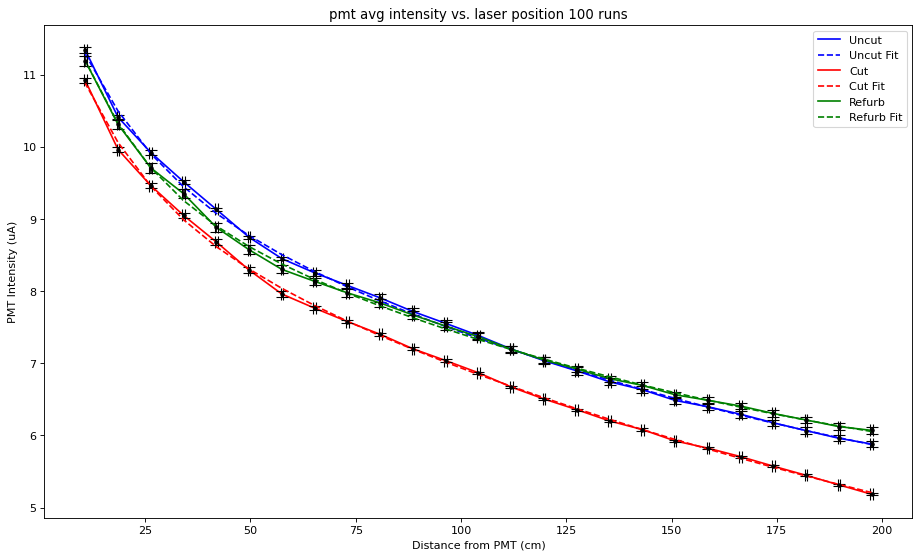

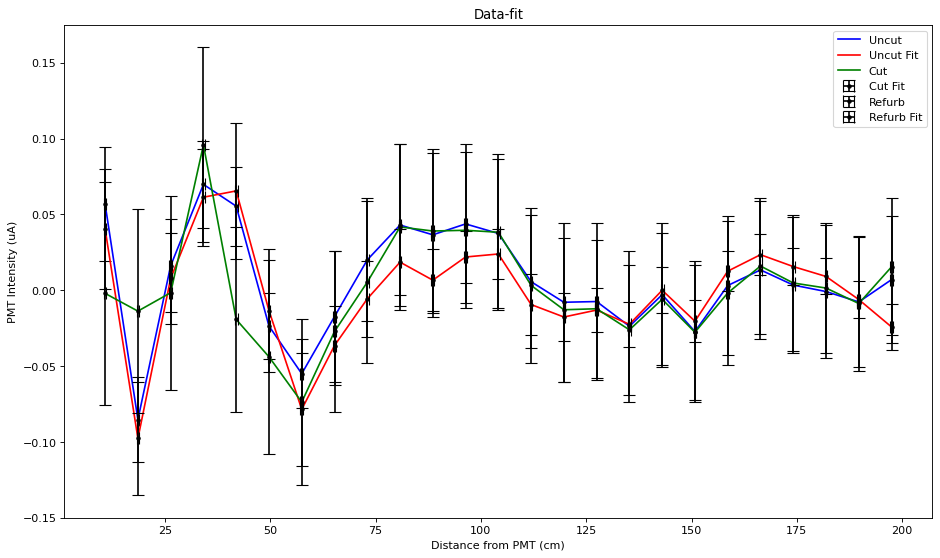

In [39]:
# Individual Fits w/ const (One Graph)

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,pmt_uncut_no_outliers_means,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,uncut_fit_c,color='b', linestyle='dashed')
# uncut error bars
plt.plot(pos,pmt_cut_no_outliers_means,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_fit_c,color='r', linestyle='dashed')
plt.plot(pos,pmt_ref_no_outliers_means,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_fit_c,color='g', linestyle='dashed')
plt.title("pmt avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,pmt_uncut_no_outliers_means-uncut_fit_c,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means-uncut_fit_c, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_cut_no_outliers_means-cut_fit_c,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means-cut_fit_c, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_means-ref_fit_c,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means-ref_fit_c, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)

plt.title("Data-fit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

In [44]:
# Joint fit (w/ const)

def joint_minimization_c(Q,a,b,A_L,A_S,A_x,R):
    data=np.concatenate([pmt_uncut_no_outliers_means,pmt_cut_no_outliers_means,pmt_ref_no_outliers_means])
    model=Q*np.concatenate([Attenuation_w_Reflection_w_const(pos,a,b,A_L,A_S,A_x,R,UncutL),Attenuation_w_const(pos,a,b,A_L,A_S,A_x),Attenuation_w_Reflection_w_const(pos,a,b,A_L,A_S,A_x,R,RefurbL)])
    err=np.concatenate([pmt_uncut_no_outliers_std,pmt_cut_no_outliers_std,pmt_ref_no_outliers_std])
    cost=(data-model)/err
    return np.sum(cost**2)

# Create a Minuit object
Joint_Min_c = Minuit(joint_minimization_c, Q=11, a=.73, b=0, A_L=450, A_S=20, A_x=100, R=0)

# Perform the minimization
result1 = Joint_Min_c.migrad()


# Print the result
print("Minimization result: Joint Fit (all three)")
print(result1)
cov_matrix_Joint=Joint_Min_c.covariance
param_errors1=Joint_Min_c.errors
corr_matrix_Joint = cov_matrix_Joint / np.outer(param_errors1, param_errors1)
print(corr_matrix_Joint)
print("Optimal parameters:", Joint_Min_c.values)
print("Parameters Errors:", Joint_Min_c.errors)

uncut_Joint_c=Joint_Min_c.values['Q']*Attenuation_w_Reflection_w_const(pos,Joint_Min_c.values['a'],Joint_Min_c.values['b'],Joint_Min_c.values['A_L'],Joint_Min_c.values['A_S'],Joint_Min_c.values['A_x'],Joint_Min_c.values['R'],UncutL)
cut_Joint_c=Joint_Min_c.values['Q']*Attenuation_w_const(pos,Joint_Min_c.values['a'],Joint_Min_c.values['b'],Joint_Min_c.values['A_L'],Joint_Min_c.values['A_S'],Joint_Min_c.values['A_x'])
ref_Joint_c=Joint_Min_c.values['Q']*Attenuation_w_Reflection_w_const(pos,Joint_Min_c.values['a'],Joint_Min_c.values['b'],Joint_Min_c.values['A_L'],Joint_Min_c.values['A_S'],Joint_Min_c.values['A_x'],Joint_Min_c.values['R'],RefurbL)

Minimization result: Joint Fit (all three)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 182.9                      │              Nfcn = 425              │
│ EDM = 1.6e-05 (Goal: 0.0002)     │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬─────────

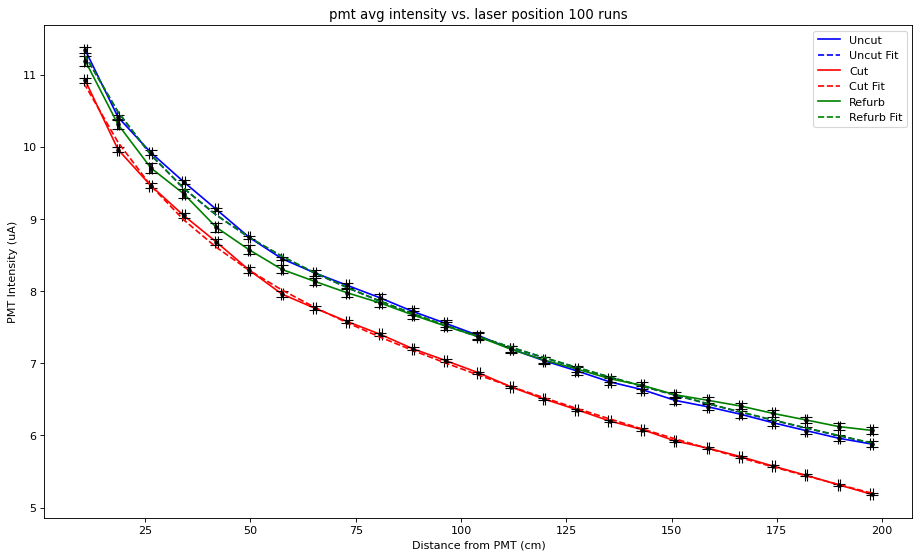

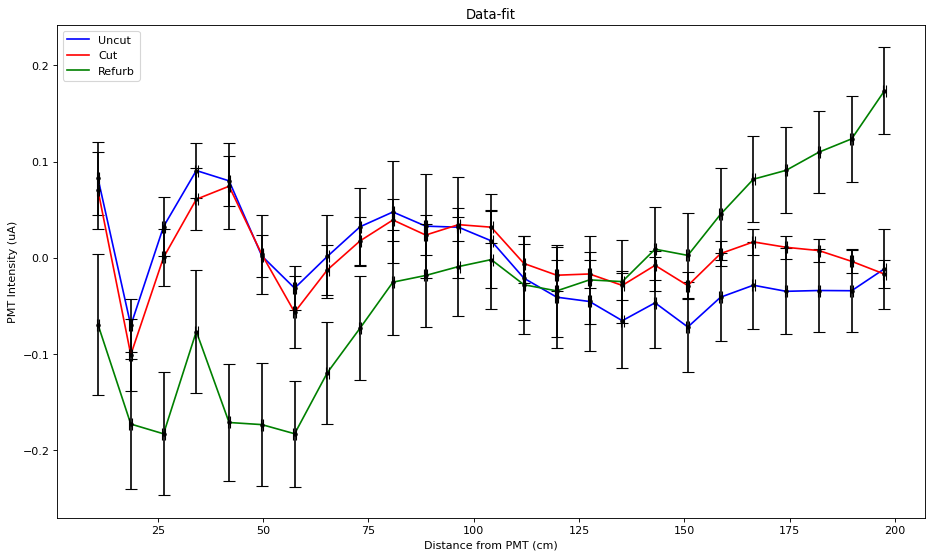

In [46]:
# Joint Fits_const (One Graph)

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,pmt_uncut_no_outliers_means,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,uncut_Joint_c,color='b', linestyle='dashed')

plt.plot(pos,pmt_cut_no_outliers_means,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_Joint_c,color='r', linestyle='dashed')

plt.plot(pos,pmt_ref_no_outliers_means,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_Joint_c,color='g', linestyle='dashed')

plt.title("pmt avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,pmt_uncut_no_outliers_means-uncut_Joint_c,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means-uncut_Joint_c, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_cut_no_outliers_means-cut_Joint_c,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means-cut_Joint_c, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_means-ref_Joint_c,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means-ref_Joint_c, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)

plt.title("Data-fit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut','Cut','Refurb'])
plt.show()

In [21]:
# Try different reflection parameters for long/short attenuation

def Attenuation_w_Reflection2(x, a, A_L, A_S, S, T, L):
    return Attenuation(x,a,A_L,A_S)+S*a*np.exp(-(x)/A_L)+T*np.abs(1-a)*np.exp(-(x)/A_S)

def minimize_with_reflection_uncut2(Q, a, A_L, A_S,S,T):
    res=(pmt_uncut_no_outliers_means-Q*Attenuation_w_Reflection2(pos,a,A_L,A_S,S,T,UncutL))/pmt_uncut_no_outliers_std
    return np.sum(res**2)
def minimize_with_reflection_cut2(Q, a, A_L, A_S,S,T):
    AveL=(UncutL+RefurbL)/2
    res=(pmt_cut_no_outliers_means-Q*Attenuation_w_Reflection2(pos,a,A_L,A_S,S,T,AveL))/pmt_cut_no_outliers_std
    return np.sum(res**2)
def minimize_with_reflection_ref2(Q, a, A_L, A_S,S,T):
    res=(pmt_ref_no_outliers_means-Q*Attenuation_w_Reflection2(pos,a,A_L,A_S,S,T,RefurbL))/pmt_ref_no_outliers_std
    return np.sum(res**2)

In [27]:
#Individual fits2
#Uncut
# Create a Minuit object
uncut_Min2 = Minuit(minimize_with_reflection_uncut2, Q=11.8, a=.73, A_L=450, A_S=20,S=0,T=0)

# Perform the minimization
result = uncut_Min2.migrad()

# Print the result
print("Minimization result: Fiber with Reflection (Uncut)")
print(result)
cov_matrix_uncut2=uncut_Min2.covariance
param_errors=uncut_Min2.errors
corr_matrix_uncut2 = cov_matrix_uncut2 / np.outer(param_errors, param_errors)
print(corr_matrix_uncut2)
print("Optimal parameters:", uncut_Min2.values)
print("Parameters Errors:", uncut_Min2.errors)

#Cut
# Create a Minuit object
cut_Min2 = Minuit(minimize_with_reflection_cut2, Q=11.8, a=.73, A_L=450, A_S=20,S=0,T=0)

# Perform the minimization
result = cut_Min2.migrad()

# Print the result
print("Minimization result: Fiber with Reflection (Cut)")
print(result)
cov_matrix_cut2=cut_Min2.covariance
param_errors=cut_Min2.errors
corr_matrix_cut2 = cov_matrix_cut2 / np.outer(param_errors, param_errors)
print(corr_matrix_cut2)
print("Optimal parameters:", cut_Min2.values)
print("Parameters Errors:", cut_Min2.errors)


#Refurb
# Create a Minuit object
ref_Min2 = Minuit(minimize_with_reflection_ref2, Q=13, a=.7, A_L=300, A_S=20,S=0.1,T=0.1)

# Perform the minimization
result = ref_Min2.migrad()

# Print the result
print("Minimization result: Fiber with Reflection (Refurb)")
print(result)
cov_matrix_ref2=ref_Min2.covariance
param_errors=ref_Min2.errors
corr_matrix_ref2 = cov_matrix_ref2 / np.outer(param_errors, param_errors)
print(corr_matrix_ref2)
print("Optimal parameters:", ref_Min2.values)
print("Parameters Errors:", ref_Min2.errors)

uncut_fit2=uncut_Min2.values['Q']*Attenuation_w_Reflection2(pos,uncut_Min2.values['a'],uncut_Min2.values['A_L'],uncut_Min2.values['A_S'],uncut_Min2.values['S'],uncut_Min2.values['T'],UncutL)
cut_fit2=cut_Min2.values['Q']*Attenuation_w_Reflection2(pos,cut_Min2.values['a'],cut_Min2.values['A_L'],cut_Min2.values['A_S'],cut_Min2.values['S'],cut_Min2.values['T'],(UncutL+RefurbL)/2)
ref_fit2=ref_Min2.values['Q']*Attenuation_w_Reflection2(pos,ref_Min2.values['a'],ref_Min2.values['A_L'],ref_Min2.values['A_S'],ref_Min2.values['S'],ref_Min2.values['T'],RefurbL)

Minimization result: Fiber with Reflection (Uncut)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 37.88                      │              Nfcn = 223              │
│ EDM = 1.57e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬─

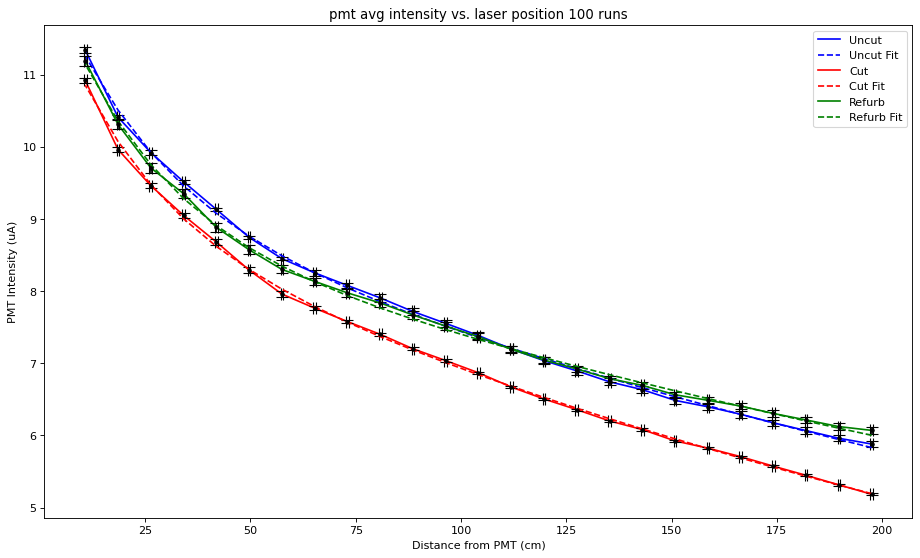

In [28]:
# Individual Fits2 (One Graph)

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,pmt_uncut_no_outliers_means,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,uncut_fit2,color='b', linestyle='dashed')

plt.plot(pos,pmt_cut_no_outliers_means,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_fit2,color='r', linestyle='dashed')

plt.plot(pos,pmt_ref_no_outliers_means,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_fit2,color='g', linestyle='dashed')

plt.title("pmt avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

In [33]:
# Joint (all three) 2

def joint_minimization_all2(Q,a,A_L,A_S,S,T):
    data=np.concatenate([pmt_uncut_no_outliers_means,pmt_cut_no_outliers_means,pmt_ref_no_outliers_means])
    model=Q*np.concatenate([Attenuation_w_Reflection2(pos,a,A_L,A_S,S,T,UncutL),Attenuation(pos,a,A_L,A_S),Attenuation_w_Reflection2(pos,a,A_L,A_S,S,T,RefurbL)])
    err=np.concatenate([pmt_uncut_no_outliers_std,pmt_cut_no_outliers_std,pmt_ref_no_outliers_std])
    cost=(data-model)/err
    return np.sum(cost**2)

# Create a Minuit object
Joint_Min2 = Minuit(joint_minimization_all2, Q=11, a=.73, A_L=450, A_S=20, S=0, T=0)

# Perform the minimization
result1 = Joint_Min2.migrad()


# Print the result
print("Minimization result: Joint Fit (all three)")
print(result1)
cov_matrix_Joint=Joint_Min2.covariance
param_errors1=Joint_Min2.errors
corr_matrix_Joint = cov_matrix_Joint / np.outer(param_errors1, param_errors1)
print(corr_matrix_Joint)
print("Optimal parameters:", Joint_Min2.values)
print("Parameters Errors:", Joint_Min2.errors)

uncut_Joint_all_fit2=Joint_Min2.values['Q']*Attenuation_w_Reflection2(pos,Joint_Min2.values['a'],Joint_Min2.values['A_L'],Joint_Min2.values['A_S'],Joint_Min2.values['S'],Joint_Min2.values['T'],UncutL)
cut_Joint_all_fit2=Joint_Min2.values['Q']*Attenuation(pos,Joint_Min2.values['a'],Joint_Min2.values['A_L'],Joint_Min2.values['A_S'])
ref_Joint_all_fit2=Joint_Min2.values['Q']*Attenuation_w_Reflection2(pos,Joint_Min2.values['a'],Joint_Min2.values['A_L'],Joint_Min2.values['A_S'],Joint_Min2.values['S'],Joint_Min2.values['T'],RefurbL)

Minimization result: Joint Fit (all three)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 579.1                      │              Nfcn = 396              │
│ EDM = 3.61e-05 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬─────────

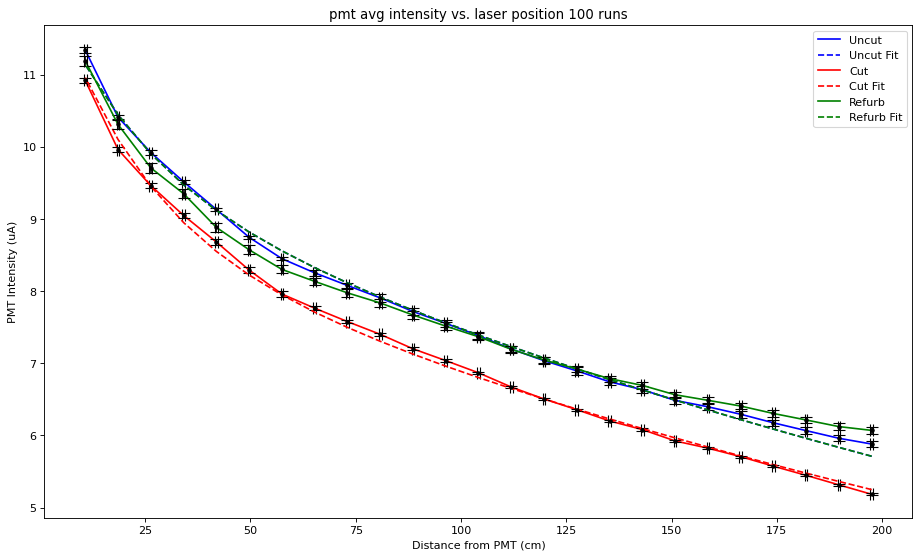

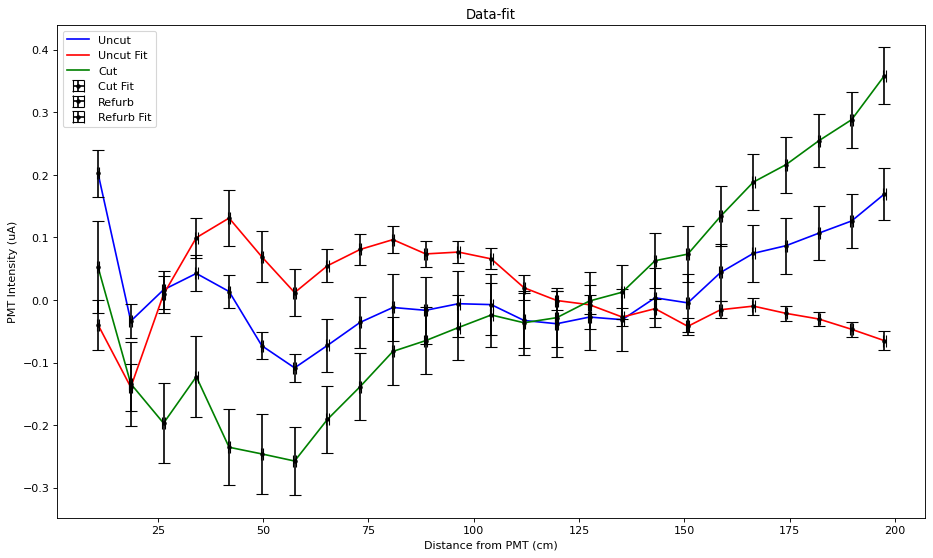

In [37]:
# Joint Fits2 (One Graph)

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,pmt_uncut_no_outliers_means,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,uncut_Joint_all_fit2,color='b', linestyle='dashed')

plt.plot(pos,pmt_cut_no_outliers_means,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_Joint_all_fit2,color='r', linestyle='dashed')

plt.plot(pos,pmt_ref_no_outliers_means,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_Joint_all_fit2,color='g', linestyle='dashed')

plt.title("pmt avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,pmt_uncut_no_outliers_means-uncut_Joint_all_fit2,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means-uncut_Joint_all_fit2, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_cut_no_outliers_means-cut_Joint_all_fit2,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means-cut_Joint_all_fit2, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_means-ref_Joint_all_fit2,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means-ref_Joint_all_fit2, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)

plt.title("Data-fit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

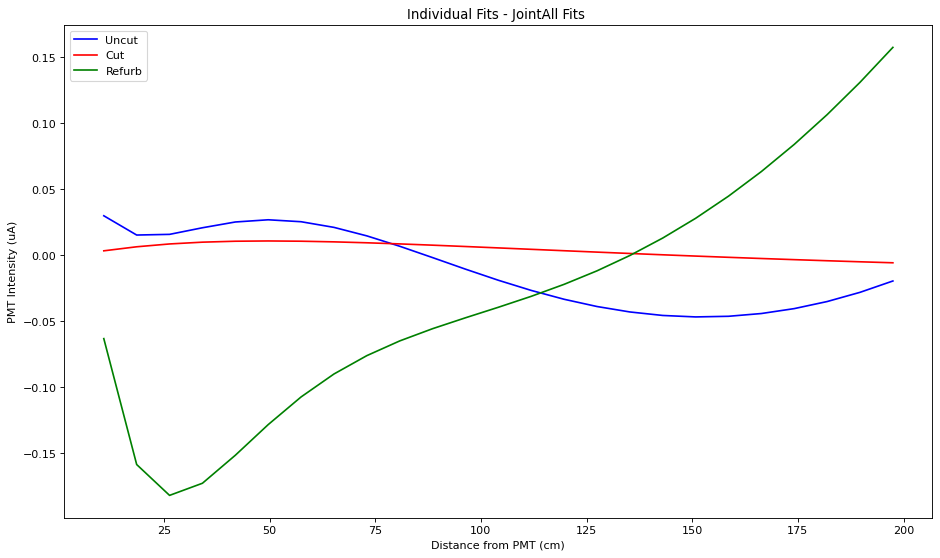

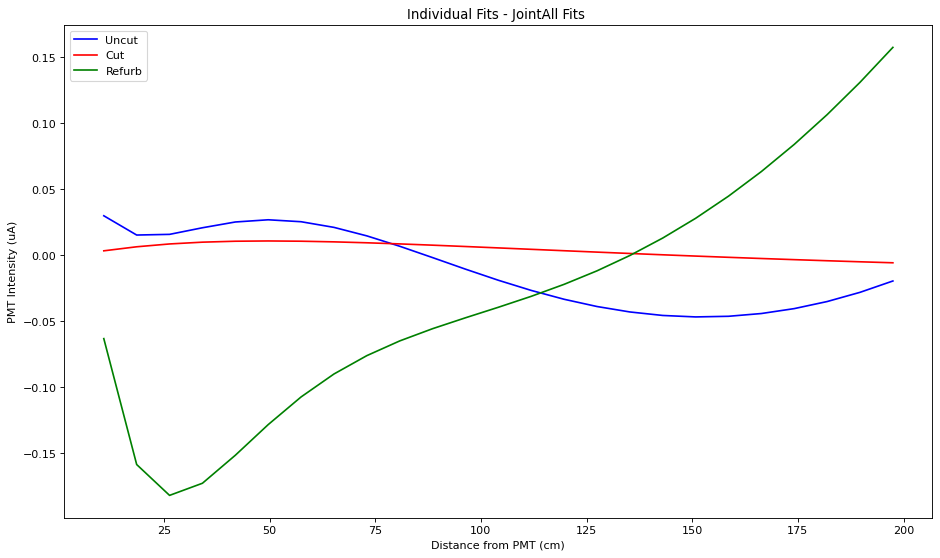

In [24]:
# Residuals (Ind - JointAll)

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,uncut_fit-uncut_Joint_all_fit,color='b')
plt.plot(pos,cut_fit-cut_Joint_all_fit,color='r')
plt.plot(pos,ref_fit-ref_Joint_all_fit,color='g')
plt.title("Individual Fits - JointAll Fits ")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut','Cut', 'Refurb'])
plt.show()

# Residuals (Ind - JointAll)

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,uncut_fit-uncut_Joint_all_fit,color='b')
plt.plot(pos,cut_fit-cut_Joint_all_fit,color='r')
plt.plot(pos,ref_fit-ref_Joint_all_fit,color='g')
plt.title("Individual Fits - JointAll Fits ")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut','Cut', 'Refurb'])
plt.show()

In [61]:
# Try a mixed lon/short attenuation term

def Attenuation_mix(x, a, b, A_L, A_S ):
    return a*np.exp(-(x)/A_L)+b*np.exp(-(x)/A_S)+(1-a-b)*np.exp(-x*(1/A_L+1/A_S))

def Attenuation_w_Reflection_mix(x, a, b, A_L, A_S, R, L):
    return Attenuation_mix(x,a,b,A_L,A_S)+R*Attenuation_mix(2*L-x,a,b,A_L,A_S)

def minimize_mix_uncut(Q, a, b, A_L, A_S,R):
    res=(pmt_uncut_no_outliers_means-Q*Attenuation_w_Reflection_mix(pos,a,A_L,A_S,S,T,UncutL))/pmt_uncut_no_outliers_std
    return np.sum(res**2)
def minimize_mix_cut(Q, a, b, A_L, A_S):
    res=(pmt_cut_no_outliers_means-Q*Attenuation_mix(pos,a,b,A_L,A_S))/pmt_cut_no_outliers_std
    return np.sum(res**2)
def minimize_mix_ref(Q, a, b, A_L, A_S,R):
    res=(pmt_ref_no_outliers_means-Q*Attenuation_w_Reflection_mix(pos,a,b,A_L,A_S,R,RefurbL))/pmt_ref_no_outliers_std
    return np.sum(res**2)

In [62]:
# Joint (all three) Mixed

def joint_minimization_mix(Q,a,b,A_L,A_S,R):
    data=np.concatenate([pmt_uncut_no_outliers_means,pmt_cut_no_outliers_means,pmt_ref_no_outliers_means])
    model=Q*np.concatenate([Attenuation_w_Reflection_mix(pos,a,b,A_L,A_S,R,UncutL),Attenuation_mix(pos,a,b,A_L,A_S),Attenuation_w_Reflection_mix(pos,a,b,A_L,A_S,R,RefurbL)])
    err=np.concatenate([pmt_uncut_no_outliers_std,pmt_cut_no_outliers_std,pmt_ref_no_outliers_std])
    cost=(data-model)/err
    return np.sum(cost**2)

# Create a Minuit object
Joint_Min_mix = Minuit(joint_minimization_mix, Q=11, a=.73, b=0.2, A_L=450, A_S=20, R=0)

# Perform the minimization
result1 = Joint_Min_mix.migrad()


# Print the result
print("Minimization result: Joint Fit (all three)")
print(result1)
cov_matrix_Joint=Joint_Min_mix.covariance
param_errors1=Joint_Min_mix.errors
corr_matrix_Joint = cov_matrix_Joint / np.outer(param_errors1, param_errors1)
print(corr_matrix_Joint)
print("Optimal parameters:", Joint_Min_mix.values)
print("Parameters Errors:", Joint_Min_mix.errors)

uncut_Joint_all_fit_mix=Joint_Min_mix.values['Q']*Attenuation_w_Reflection_mix(pos,Joint_Min_mix.values['a'],Joint_Min_mix.values['b'],Joint_Min_mix.values['A_L'],Joint_Min_mix.values['A_S'],Joint_Min_mix.values['R'],UncutL)
cut_Joint_all_fit_mix=Joint_Min_mix.values['Q']*Attenuation_mix(pos,Joint_Min_mix.values['a'],Joint_Min_mix.values['b'],Joint_Min_mix.values['A_L'],Joint_Min_mix.values['A_S'])
ref_Joint_all_fit_mix=Joint_Min_mix.values['Q']*Attenuation_w_Reflection_mix(pos,Joint_Min_mix.values['a'],Joint_Min_mix.values['b'],Joint_Min_mix.values['A_L'],Joint_Min_mix.values['A_S'],Joint_Min_mix.values['R'],RefurbL)

Minimization result: Joint Fit (all three)
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 182.9                      │              Nfcn = 736              │
│ EDM = 1.27e-05 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬─────────

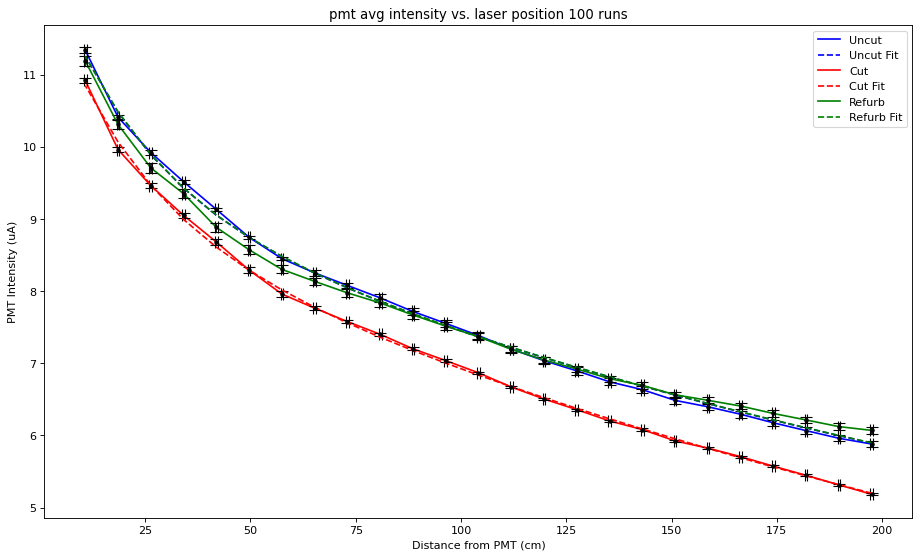

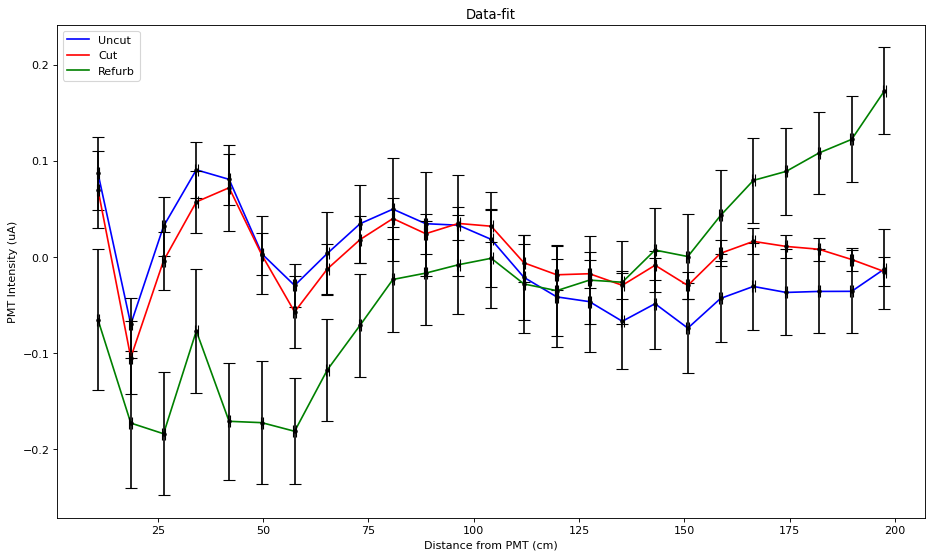

In [63]:
# Joint Fits Mixed (One Graph)

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,pmt_uncut_no_outliers_means,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,uncut_Joint_all_fit_mix,color='b', linestyle='dashed')

plt.plot(pos,pmt_cut_no_outliers_means,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,cut_Joint_all_fit_mix,color='r', linestyle='dashed')

plt.plot(pos,pmt_ref_no_outliers_means,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)
plt.plot(pos,ref_Joint_all_fit_mix,color='g', linestyle='dashed')

plt.title("pmt avg intensity vs. laser position 100 runs")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Uncut Fit','Cut','Cut Fit','Refurb','Refurb Fit'])
plt.show()

# Residuals (data-fit)

fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(pos,pmt_uncut_no_outliers_means-uncut_Joint_all_fit_mix,color='b')
plt.errorbar(pos,pmt_uncut_no_outliers_means-uncut_Joint_all_fit_mix, xerr=L_err,yerr=pmt_uncut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_cut_no_outliers_means-cut_Joint_all_fit_mix,color='r')
plt.errorbar(pos,pmt_cut_no_outliers_means-cut_Joint_all_fit_mix, xerr=L_err,yerr=pmt_cut_no_outliers_std, fmt=".", color="k",capsize=5)

plt.plot(pos,pmt_ref_no_outliers_means-ref_Joint_all_fit_mix,color='g')
plt.errorbar(pos,pmt_ref_no_outliers_means-ref_Joint_all_fit_mix, xerr=L_err,yerr=pmt_ref_no_outliers_std, fmt=".", color="k",capsize=5)

plt.title("Data-fit")
plt.xlabel("Distance from PMT (cm)")
plt.ylabel("PMT Intensity (uA)")
plt.legend(['Uncut', 'Cut','Refurb'])
plt.show()